# Training

In [1]:
# Import our model
from model import MVP, LSTM_MVP

# Libraries for the data
import pandas as pd

import numpy as np
import torch
import torch.nn as nn

# Get the sector tickers
from sector import *

# Process the data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
tks = get_ticker_dict(sectors)
descs = get_desc_dict(sectors)

Get our data

In [3]:
sectors_data = {}
for k in tks.keys():
    sectors_data[k] = pd.read_csv('data/sectors/TA/{}_7yr_daily.csv'.format(k))
    sectors_data[k].index = pd.to_datetime(sectors_data[k]["date"])
    sectors_data[k].drop(['ticker', 'descr', 'date'], axis=1, inplace=True)

In [4]:
sp5 = pd.read_csv('data/sectors/SP500_7yr_daily.csv')
sp5.index = pd.to_datetime(sp5["date"])
sp5.drop(['ticker', 'descr', 'date'], axis=1, inplace=True)
labels = pd.read_csv('data/sectors/sector_labels.csv')
labels.index = pd.to_datetime(labels["date"])
labels.drop('date', axis=1, inplace=True)
labels.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
ordering = []
for k in sectors_data.keys():
    ordering += [k]

In [6]:
'''
converts a dataframe to be valid input data and labels by lining up dates and adding a row of data for each sector (and the S&P)
'''
def data_to_XY(sectors, sp5, labels):
    closest_date = None
    
    # 1 entry for every month date
    stacks = len(labels)
    # Number of stocks (sectors & the SP500)
    stack_height = len(sectors.keys()) + 1 
    # 1 col for every feature (subtract ticker column and description column)
    stack_width = len(sectors["XLB"].columns)
    
    X = torch.zeros((stacks, stack_height, stack_width), dtype=torch.float64)
    
    # Go through dates and gather rows of each sector & sp5
    for i, date in enumerate(labels.index):
        newdf = sp5.index[sp5.index <= date]

        ### Add SP5 data to row
        # Get the last date before the new month
        closest_date = newdf.values[-1]
        
        # Do i need to deep copy here?
        row = torch.zeros((stack_width))
        row[0:2] = torch.tensor(sp5.iloc[sp5.index == closest_date].values[0])
        X[i,0] = row
        
        row_counter = 0
        ### Add sectors' data to row
        for k in sectors.keys():
            sector = sectors[k]
            row_counter += 1
            sector_row = torch.zeros((stack_width))
            
            # Already have the last date, make sure the sectors align with that date (have a row of information for each date)
            # If the sector started at a date beyond our last date, ignore it (all 0s)
            if sector.index.values[0] > closest_date:
                # print("No {} data at/before date: {}... settings to 0s".format(k, closest_date))
                X[i,row_counter] = sector_row
            else:
                # Should expect to have data here. If not, this is a problem (has SP5 data and previous sector data, but this would imply a hole in the data)
                if len(sector.iloc[sector.index == closest_date]) != 1:
                    print("ERROR: No {} data for date {} where expected. Using previous day of {}.".format(k, closest_date, sector.iloc[sector.index < closest_date].index[-1]))
                    sector_row = torch.tensor(sector.iloc[sector.index < closest_date].values[-1,:])
                else:
                    sector_row = torch.tensor(sector.iloc[sector.index == closest_date].values[0])
                
                X[i,row_counter] = sector_row
            
    # Prepare the labels
    Y = torch.zeros((labels.shape[0], labels.shape[1]), dtype=torch.float64)
    for i, col in enumerate(labels.columns):
        index = ordering.index(descs[col])
        Y[:,index] = torch.tensor(labels[col].values)
    
    return X, Y
    
X, Y = data_to_XY(sectors_data, sp5, labels)

### Examine Data
Our X data consists of 3 dimensions: (monthly data points, each sector of the S&P500 and the S&P500 itself, TA features for each stock)

In [7]:
X.shape

torch.Size([82, 12, 94])

Our Y data consists of 2 dimensions (monthly data points, 1 value for each of the sectors). Note that the sector dimension is 1 less than the X data (no labels for S&P500 data)

In [8]:
Y.shape

torch.Size([82, 11])

### Train/Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=226)

### Scale our data

In [10]:
sclr = StandardScaler()
num_instances, num_stocks, num_features = X_train.shape
X_train = X_train.reshape((-1, num_features))
X_train = sclr.fit_transform(X_train)

In [11]:
# Return X_train data to how it was
X_train = torch.from_numpy(X_train.reshape((num_instances, num_stocks, num_features)))

In [12]:
# This will be for testing
num_instances, num_stocks, num_features = X_test.shape
X_test = X_test.reshape((-1, num_features))
X_test = sclr.transform(X_test)
X_test = torch.from_numpy(X_test.reshape((num_instances, num_stocks, num_features)))

### Dataset and Dataloader

In [13]:
class StockDataset(torch.utils.data.Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.Y[index]

In [14]:
train_dataset = StockDataset(X_train, y_train)
test_dataset = StockDataset(X_test, y_test)
params = {'batch_size': 1,
          'shuffle': False,
          'num_workers': 0}
train_dataloader = torch.utils.data.DataLoader(train_dataset, **params)
test_dataloader = torch.utils.data.DataLoader(test_dataset, **params)

In [15]:
# # Input Dimension is the number of features * number of stocks (because it will be flattened),
# # Output Dimension is the number of stocks - 1 (because only predicting if each stock will over/underperform the S&P500, -1 because S&P500 included in data)
# # Output Dimension is 2, indicating we want 2 values, each one determining if each stock will over/underperform the S&P500, respectively
# num_classes = 2 # Overperform/underperform
# model = MVP(X.shape[1] * X.shape[2], Y.shape[1] * num_classes)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

In [16]:
num_classes = 2 # Overperform/underperform
lstm_layers = 3
lstm_hidden_size = 1500
batch_size = 1
model = LSTM_MVP(X.shape[1] * X.shape[2], Y.shape[1] * num_classes, lstm_num_layers=lstm_layers, lstm_hidden_size=lstm_hidden_size)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0005)

In [17]:
model = model.to('cuda')

In [18]:
# Computes the % accuracy of our model vs actual results (does not weight how far off our model was, unlike cross entropy)
def compute_accuracy(Y_hat, Y, debug=False):
  bin_preds = Y_hat.argmax(dim=1)
  if debug:
    print(((Y - bin_preds) == 0).sum().item(), 'correct out of', len(Y))
    print(f'{((Y - bin_preds) == 0).sum().item() / len(Y) * 100.:0.2f}%')
  return ((Y - bin_preds) == 0).sum().item() / len(Y) * 100
  

def clean_nans(Y_hat, Y):
  # print("Was shape", Y_hat.shape, Y.shape)
  # with torch.no_grad():
  nan_mask = Y < 0
  # Remove the NaN column from our labels
  Y = Y[~nan_mask]
  # Remove corresponding column from our prediction
  Y_hat = Y_hat[~nan_mask]
  # print("New shape", Y_hat.shape, Y.shape)
  return Y_hat, Y

def train(model, optimizer, epochs=50, ret_loss=False):

  criterion = nn.CrossEntropyLoss()
  # loss_data = torch.zeros((epochs, len(train_dataloader)))
  # val_loss_data = torch.zeros((epochs, len(test_dataloader)))
  
  loss_data = torch.zeros((epochs))
  val_loss_data = torch.zeros((epochs))
  train_accuracy = torch.zeros((epochs))
  val_accuracy = torch.zeros((epochs))
  
  for e in range(epochs):

    run_loss = 0
    batch_loss = 0.0
    batch_accuracy = torch.zeros((len(train_dataloader)))
    
    model.train()
    h = model.init_hidden(batch_size) # intialize the hidden state
    for i, data in enumerate(train_dataloader, 0):
      X, Y = data
      Y = Y.to(torch.long).reshape(-1).cuda()
      X = X.float().cuda()
      optimizer.zero_grad()

      h = tuple([each.data for each in h])
      pred, h  = model(X, h)
      pred = pred.reshape(-1, 2)
      
      # pred takes shape (11 rows x 2 cols), each of the 11 sectors have 2 predictions (over/underperform)
      # y will be a 1-D array of size 11, one 1/0 value for each row (sector)
      
      # If a sector does not exist yet (label is NaN), NaN values should not be included in loss calculation
      if (Y < 0).sum() > 0:
        pred, Y = clean_nans(pred, Y)
      
      batch_accuracy[i] = compute_accuracy(pred, Y)
      loss = criterion(pred, Y)
      loss.backward()
      optimizer.step()

      # print statistics
      l = loss.item()
      # loss_data[e,i] = l
      batch_loss += l
      run_loss += l
      # if i % 10 == 9:    # print every 10 mini-batches
      #     print(f'[{e + 1}, {i + 1:5d}] loss: {batch_loss / 2000:.3f}')
      #     batch_loss = 0.0
      
    val_run_loss = 0
    
    model.eval()
    val_batch_accuracy = torch.zeros((len(test_dataloader)))
    val_h  = model.init_hidden(batch_size)
    for i, data in enumerate(test_dataloader, 0):
      with torch.no_grad():
        X, Y = data
        Y = Y.to(torch.long).reshape(-1).cuda()
        X = X.float().cuda()

        val_h = tuple([each.data for each in val_h])
        pred, val_h = model(X, val_h)
        pred = pred.reshape(-1, 2)
        
        if (Y < 0).sum() > 0:
          pred, Y = clean_nans(pred, Y)
      
        val_batch_accuracy[i] = compute_accuracy(pred, Y)
        loss = criterion(pred, Y)
        l = loss.item()
        # val_loss_data[e,i] = l
        val_run_loss += l
    
    loss_data[e] = run_loss / len(train_dataloader)
    val_loss_data [e] = val_run_loss / len(test_dataloader)
    val_accuracy[e] = val_batch_accuracy.mean()
    train_accuracy[e] = batch_accuracy.mean()
    
    if e % 50 == 49:
      print(f"Epoch {e+1} loss: {run_loss / len(train_dataloader):.3f} Accuracy: {train_accuracy[e]:0.2f}%, Val Loss: {val_run_loss / len(test_dataloader):.3f} Accuracy: {val_accuracy[e]:0.2f}%")
  print('Finished Training')
  if ret_loss:
    return loss_data, val_loss_data, train_accuracy, val_accuracy

In [19]:
train_loss, val_loss, train_accuracy, val_accuracy = train(model, optimizer, epochs=400, ret_loss=True)

Epoch 50 loss: 0.688 Accuracy: 58.19%, Val Loss: 0.691 Accuracy: 53.11%
Epoch 100 loss: 0.685 Accuracy: 58.19%, Val Loss: 0.690 Accuracy: 53.11%
Epoch 150 loss: 0.682 Accuracy: 58.84%, Val Loss: 0.689 Accuracy: 53.14%
Epoch 200 loss: 0.680 Accuracy: 58.84%, Val Loss: 0.689 Accuracy: 53.14%
Epoch 250 loss: 0.678 Accuracy: 58.84%, Val Loss: 0.689 Accuracy: 53.14%
Epoch 300 loss: 0.677 Accuracy: 58.84%, Val Loss: 0.689 Accuracy: 53.14%
Epoch 350 loss: 0.676 Accuracy: 58.84%, Val Loss: 0.690 Accuracy: 53.14%
Epoch 400 loss: 0.675 Accuracy: 58.84%, Val Loss: 0.690 Accuracy: 53.14%
Finished Training


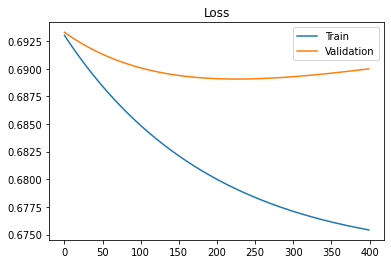

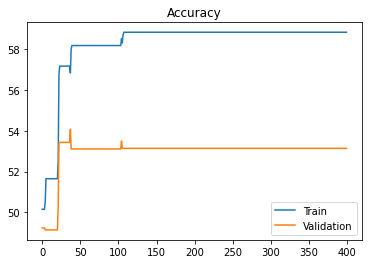

In [20]:
import matplotlib.pyplot as plt

plt.title("Loss")
plt.plot(train_loss.reshape(-1), label="Train")
plt.plot(val_loss.reshape(-1), label="Validation")
plt.legend()

plt.figure()
plt.title("Accuracy")
plt.plot(train_accuracy.reshape(-1), label="Train")
plt.plot(val_accuracy.reshape(-1), label="Validation")
plt.legend()

In [ ]:
'''
MVP 1. About 0.665 loss with basic MVP (only features layer) (0.01 lr). Validation loss unchanged.

MVP 2. With classify layer (essentially a much deeper neural network @ 0.01 lr), reached 0.691 loss. Validation loss started to come down as well!

MVP 2. @ 0.05 lr, train: 0.655, val: 0.690

MVP 2 @ 2000 epochs, 0.05 lr, train: 0.653, val: 0.692



TLT, bonds go up, yields go down
compare the 10 year vs 2 year bond (or 6 month vs 2 year), if closer together, potentially means higher risk

LSTM_MVP 1. train: 0.36, val: 1.2

2. Epoch 150 loss: 0.676, Val Loss: 0.695

2. Epoch 100 loss: 0.675, Val Loss: 0.694

2. Epoch 100 loss: 0.676, Val Loss: 0.695

2. No shuffle. Epoch 100 loss: 0.673 Accuracy: 58.84%, Val Loss: 0.694 Accuracy: 27.55%
Epoch 100 loss: 0.694 Accuracy: 49.28%, Val Loss: 0.695 Accuracy: 26.01%
Epoch 100 loss: 0.693 Accuracy: 50.78%, Val Loss: 0.694 Accuracy: 50.07%

2. Epoch 1800 loss: 0.673 Accuracy: 58.84%, Val Loss: 0.693 Accuracy: 53.14%

2. Epoch 2000 loss: 0.673 Accuracy: 58.84%, Val Loss: 0.695 Accuracy: 53.14%
'''


'\nMVP 1. About 0.665 loss with basic MVP (only features layer) (0.01 lr). Validation loss unchanged.\n\nMVP 2. With classify layer (essentially a much deeper neural network @ 0.01 lr), reached 0.691 loss. Validation loss started to come down as well!\n\nMVP 2. @ 0.05 lr, train: 0.655, val: 0.690\n\nMVP 2 @ 2000 epochs, 0.05 lr\nTrain\n\nTLT, bonds go up, yields go down\ncompare the 10 year vs 2 year bond (or 6 month vs 2 year), if closer together, potentially means higher risk\n\n'